In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth",500)
pd.options.display.max_rows = 99999

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from tabulate import tabulate

def readdata_MT5_Date(market,tf,path,start,stop):
    
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd
    
    while True:

        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        mk=str(market)
        TF="mt5.TIMEFRAME_"+str(tf)

        start_y , start_m , start_d = start.split("-")
        stop_y , stop_m , stop_d = stop.split("-")
        
        utc_from = datetime(int(start_y), int(start_m), int(start_d))
        utc_to = datetime(int(stop_y), int(stop_m), int(stop_d))
        
        rates = mt5.copy_rates_range(mk, eval(TF), utc_from, utc_to) 
    

        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume","spread"]]
        rates_frame.columns=(["time","open","high","low","close","volume","spread"])
        rates_frame=rates_frame.set_index(["time"])
        #rates_frame=rates_frame[(rates_frame.T != 0).any()]
        if rates_frame is not None:
            return rates_frame
            break

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
    
    cnt=0
    salta=0
    while True:
        cnt=cnt+1
        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            if cnt<2:
                continue
            else:
                salta=1
                break
    if salta == 0:
        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume","spread"]]
        rates_frame.columns=(["time","open","high","low","close","volume","spread"])
        rates_frame=rates_frame.set_index(["time"])
        rates_frame=rates_frame[(rates_frame.T != 0).any()]
        return rates_frame
    else:
        return pd.DataFrame()
    
def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return round(tmp)

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def check_start_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[0]]
    z=list(set(z))
    z.sort()
    return y[0],z[0]

def check_end_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[-1]]
    z=list(set(z))
    z.sort()
    return y[-1],z[-1]

def get_spread(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    try:
        if len(symbol_info)>0:
            return symbol_info.spread
    except:
        return None
    
def get_category(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['path']

def get_ETF(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['description']
    
    
def get_min_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_min

def get_max_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_max

def remove_outlier(y):
    Q1 = np.percentile(y, 10, #25
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 90, #75
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

def serialize_kmeans_model(kmeans_model):
    
    model_data = {
        'n_clusters': kmeans_model.n_clusters,
        'cluster_centers_': kmeans_model.cluster_centers_.tolist(),
        'labels_': kmeans_model.labels_.tolist(),
        'inertia_': kmeans_model.inertia_,
        'init': kmeans_model.init,
        'n_init': kmeans_model.n_init,
        'max_iter': kmeans_model.max_iter,
        'tol': kmeans_model.tol,
        'algorithm': kmeans_model.algorithm,
        'random_state': kmeans_model.random_state,
        'n_threads' : kmeans_model._n_threads
    }
    return model_data

def recreated_kmeans_model(serialized_kmeans):
    
    from sklearn.cluster import KMeans
    
    kmeans_recreated = KMeans(n_clusters=serialized_kmeans['n_clusters'],
                           init=serialized_kmeans['init'],
                           n_init=serialized_kmeans['n_init'],
                           max_iter=serialized_kmeans['max_iter'],
                           tol=serialized_kmeans['tol'],
                           algorithm=serialized_kmeans['algorithm'],
                           random_state=serialized_kmeans['random_state'])

    kmeans_recreated.cluster_centers_ = serialized_kmeans['cluster_centers_']
    kmeans_recreated.labels_ = serialized_kmeans['labels_']
    kmeans_recreated.inertia_ = serialized_kmeans['inertia_']
    kmeans_recreated._n_threads = serialized_kmeans['n_threads']

    return kmeans_recreated

def get_swap(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.swap_long , symbol_info.swap_short


def get_all_ETF_symbols(path):
    
    all_symbols = allsymbols(path)
    
    ls_temp=[]
    
    for simb in all_symbols:
    
        import MetaTrader5 as mt5
        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        symbol_info=mt5.symbol_info(simb)
        if symbol_info!=None:
            symbol_info_dict = mt5.symbol_info(simb)._asdict()
        mt5.shutdown()    

        if "ETF" in symbol_info_dict['description']:
            ls_temp.append(simb)
    return ls_temp

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8, 8)  
plt.rcParams['lines.linewidth'] = .5


def get_point(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.point

def get_cost(path,simbolo):

    df = readdata(simbolo,"M1",1440*5,path)
    point = get_point(path,simbolo)
    bpv = get_poin_values(path,simbolo)
    costi = df.spread * point * bpv
    return round(costi.mean())

import talib as ta 
import time

def level_to_condition(enter_level,history,tipo_ordine,direzione):
    enter_level=eval(enter_level)
    history["level_check"] = [True]*len(enter_level)
    if (tipo_ordine == "stop") | (tipo_ordine == "limit"):
        if (direzione == "long") & (tipo_ordine == "stop"):  
            history["level_check"] = (history.high >= enter_level)
        if (direzione == "short") & (tipo_ordine == "stop"):    
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "long") & (tipo_ordine == "limit"):  
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "short") & (tipo_ordine == "limit"):    
            history["level_check"] = (history.high >= enter_level)

    return history["level_check"]

def check_stoploss(SL,history,enter_level,BIGPOINTVALUE,direzione):

    if (SL != 0) & (direzione == "long") :
        return ((history.close - enter_level) * BIGPOINTVALUE) <= -SL
    if (SL != 0) & (direzione == "short") :
        return ((enter_level - history.close ) * BIGPOINTVALUE) <= -SL
    else:
        return [False]*len(history)
    
def check_takeprofit(TP,history,enter_level,BIGPOINTVALUE,direzione):

    if (TP != 0) & (direzione == "long"):
        return ((history.close - enter_level) * BIGPOINTVALUE) >= TP
    if (TP != 0) & (direzione == "short"):
        return ((enter_level - history.close) * BIGPOINTVALUE) >= TP
    else:
        return [False]*len(history)    
    
def check_add_rule(ADD_RULE_CONDITION,history):
    if str(ADD_RULE_CONDITION) == "False":
        return np.array([True]*len(history.iloc[:,0]))
    else:
        history["add_rule_check"]=eval(ADD_RULE_CONDITION)
        return np.array(history["add_rule_check"])

import talib as ta 
import time

def level_to_condition(enter_level,history,tipo_ordine,direzione):
    enter_level=eval(enter_level)
    history["level_check"] = [True]*len(enter_level)
    if (tipo_ordine == "stop") | (tipo_ordine == "limit"):
        if (direzione == "long") & (tipo_ordine == "stop"):  
            history["level_check"] = (history.high >= enter_level)
        if (direzione == "short") & (tipo_ordine == "stop"):    
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "long") & (tipo_ordine == "limit"):  
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "short") & (tipo_ordine == "limit"):    
            history["level_check"] = (history.high >= enter_level)

    return history["level_check"]

def check_add_rule(ADD_RULE_CONDITION,history):
    if str(ADD_RULE_CONDITION) == "False":
        return np.array([True]*len(history.iloc[:,0]))
    else:
        history["add_rule_check"]=eval(ADD_RULE_CONDITION)
        return np.array(history["add_rule_check"])



In [2]:
from numba import jit

@jit(nopython=True)
def engine_plus_2(exit_bars , entry , pnl , exit_rule , direzione , costi , price , bigpointvalue , TP , SL,index_date):
    
    ls = []
    ls_start = []
    ls_stop = []
    ls_label_ = []
    ls_entry_price = []
    ls_exit_price = []
    ex = 0
    for I in range(entry.size):
        if entry[I] & (I>ex):  # se c'è una condizione di ingresso e non c'è un trade in corso
            I=int(I+1)  # ingresoo su barra successiva 

            exit_b = 999999 # imposto max uscita barre
            if exit_b != 0: # se uscita barre è diverso da 0
                exit_b = int(I+exit_bars+1)  # imposto l'uscita a barre
            else:
                exit_b = 999999 # imposto max uscita barre
                
            if len(np.where(exit_rule[I:])[0])>0: # verifico se è presnte un evento di uscita
                er = (np.where(exit_rule[I:])[0][0] + 1 +I) # imposto uscita a exit rule
            else:
                er = 999999 # se non ci sono uscite imposta max uscita  
                    
            fe = exit_b  # imposto first exit uguale a uscita barre
            ls_label = ["Exit bar","Stop loss","Take profit"]  #definisco l'indice delle etichette x exit bar
    
            if exit_b >= er: # controllo la prima uscita tra exit bar e exit rule 
                fe=er # imposto first exit uguale a exit rule 
                ls_label = ["Exit Rule","Stop loss","Take profit"] #definisco l'indice delle etichette x exit rule
 
            tmp_cumsum = np.cumsum(pnl[I:fe])   ### imposto il trade tra apertura e chiusura 
        
            sl = np.where(tmp_cumsum<=-SL)[0] ##verifico se scatta SL durante il trade 
            if len(sl)>0: # verifico se scatta lo SL
                sl=sl[0]+1+I # imposto indice 
            else:
                sl = 999999 # imposta stop loss a max uscita
                  
            tp = np.where(tmp_cumsum>=TP)[0] # verifico se scatta TP durante il trade 
            if len(tp)>0: # verifico se scatta il TP 
                tp=tp[0]+1+I # imposto indice 
            else:
                tp = 999999 # imposta take profit a max uscita
            
            ex = np.array([int(fe), int(sl), int(tp)]) #creo lista delle uscite 
            
            min_index = np.argmin(ex) # individuo l'indice del primo evento di uscita 
            ex = ex[min_index] # imposto il punto di uscita del trade 
            label = ls_label[min_index] # imposto la label di uscita 
         
            if ex >= len(price): # solo per trade aperto 
                I=len(price)-1 #imposto il prezzo di uscita con l'ulitmo valore disonibile della rete 
                ex=I # uscita uguale al ingresso
                label="Trade Opened" # imposto la label per trade aperto
                
            operation = ((price[ex]-price[I])*bigpointvalue) #calcolo pnl del operazione 
            if direzione == "short": # controllo se la direzione è short
                operation = -operation # se è short inverto il segno 
            
            ls.append(operation-costi) # appendo l'operazione meno i costi 
            ls_start.append(index_date[I]) # appendo la data di ingresso del trade 
            ls_stop.append(index_date[ex]) # appendo la data di uscita del trade 
            ls_label_.append(label) # appendo la label del trade 
            ls_entry_price.append(price[I]) # appendo il prezzo di ingresso 
            ls_exit_price.append(price[ex]) # appendo il prezzo di uscita 
            
    return ls_start , ls_stop , ls_entry_price , ls_exit_price , ls , ls_label_


def BK_Opt(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION,opt):

    import talib as ta
    
    price = np.array(history.open)
    index_date = np.array(history.index)
    pnl = (np.roll(price , -1) - price) * bigpointvalue
    if direzione == "short":
        pnl = -pnl
            
    entry = np.array(np.array(eval(entry_rule)) & np.array(level_to_condition(level,history,tipo_ordine,direzione)) & check_add_rule(ADD_RULE_CONDITION,history))
    
    if exit_rule != "False":
        exit_rule = np.array(eval(exit_rule))
    else:
        exit_rule = np.array([False]*len(entry)) 

    trade_list = engine_plus_2(exit_bars , entry , pnl , exit_rule , direzione , costi , price , bigpointvalue,TP,SL,index_date)

    if opt:
        if len(trade_list[0])>0:
            return trade_list[4]
        else:
            return []
    else:
        if len(trade_list[0])>0:
            tradelist = pd.DataFrame(trade_list).T
            tradelist.columns = (["entry_time","exit_time","entry_price","exit_price","operations","label_event"])
            tradelist.set_index(["exit_time"],inplace=True)
            tradelist.index = pd.to_datetime(tradelist.index)
            return tradelist
        else:
            return pd.DataFrame(columns=(["entry_time","exit_time","operations"]))

In [ ]:
import ray
from ray_map import ray_deap_map

ray.init(log_to_driver=False)

In [ ]:
path=(r"C:\Program Files\AMP Global (USA) MT5 Exchange-Traded Futures Only 2\terminal64.exe")

#path=(r"C:\Program Files\AMP Global (EU) MT5 Terminal 1\terminal64.exe")

SIMBOLO = "USDCHF" 

bigpointvalue = get_poin_values(path,SIMBOLO)
utc_offset = "Etc/GMT+1"

dataset = readdata_MT5_Date(SIMBOLO,"M30",path,"2012-01-01","2024-01-01")
#dataset.index=dataset.index.tz_localize("UTC").tz_convert(utc_offset)
dataset.index=pd.to_datetime(dataset.index)
#dataset = dataset.resample("5T").max()
#dataset = dataset.ffill()
dataset = dataset.fillna(0)

RESAMPLE = "1H"
dataset = dataset.resample(RESAMPLE).agg({'open': 'first','high': 'max','low':'min','close':'last','volume':'sum'}).dropna()

dataset .head(10) ,dataset.tail(10)
dataset["asset"] = SIMBOLO
dataset["tick"] = get_point(path,SIMBOLO)
dataset["costi"] = get_cost(path,SIMBOLO)
dataset["bigpointvalue"] = get_poin_values(path,SIMBOLO)
history = dataset.copy()
history.tail()

<Axes: xlabel='H'>

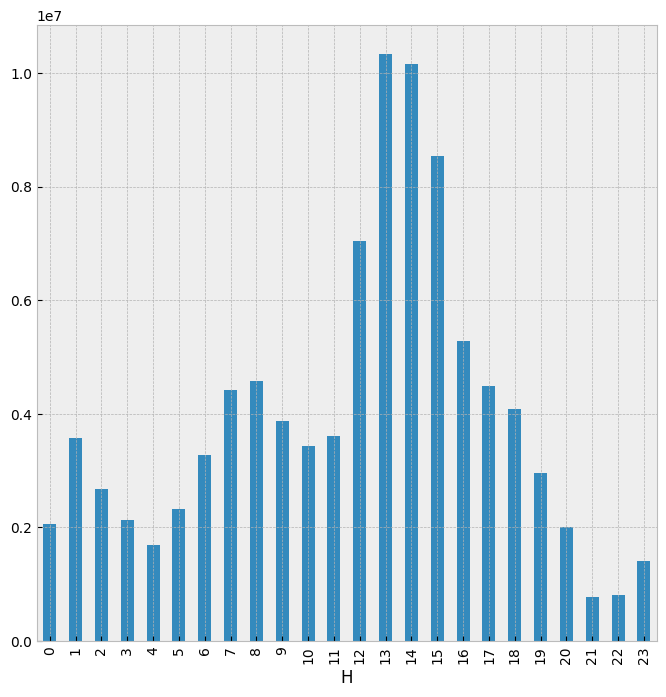

In [12]:
import random


dataset["PNL"] = dataset.volume.copy()

check_h =  dataset["PNL"].copy().to_frame()
check_h["H"]=check_h.index.hour
check_h.groupby("H").sum().PNL.plot.bar()

In [27]:
import talib as ta

ls_rules = []
ls_rules.append("[True]*len(history)")

periods = [7,11,14,20]
level = np.arange(10,100,10)

for i in periods:
    for j in level :
        ls_rules.append("ta.RSI(history.close ,"+str(i)+")>"+str(j)+"")
        ls_rules.append("ta.RSI(history.close ,"+str(i)+")<"+str(j)+"")

periods = [10,15,20,25,30]
dev = np.arange(1,3,0.25)

for i in periods:
    for j in dev :
        ls_rules.append("history.close>ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[0]") #up band
        ls_rules.append("history.close<ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[2]") #low band
        ls_rules.append("history.close<ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[0]") #up band
        ls_rules.append("history.close>ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[2]") #low band
        ls_rules.append("history.close<ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[1]") #centrer band
        ls_rules.append("history.close>ta.BBANDS(history.close, timeperiod="+str(i)+", nbdevup="+str(j)+", nbdevdn="+str(j)+")[1]") #centrer band

periods = [7,11,14,20,34,50]
for i in periods:
    for j in level :
        if  i != j:
            ls_rules.append("(ta.ADX(history.high, history.low, history.close, timeperiod="+str(i)+")>ta.ADX(history.high, history.low, history.close, timeperiod="+str(j)+"))")
            ls_rules.append("(ta.ADX(history.high, history.low, history.close, timeperiod="+str(i)+")<ta.ADX(history.high, history.low, history.close, timeperiod="+str(j)+"))")
            ls_rules.append("(ta.LINEARREG(history.close, timeperiod="+str(i)+")>ta.LINEARREG(history.close, timeperiod="+str(j)+"))")
            ls_rules.append("(ta.LINEARREG(history.close, timeperiod="+str(i)+")<ta.LINEARREG(history.close, timeperiod="+str(j)+"))")

periods = [1,2,3,4,5,6,7]
price_ls = ["open","high","low","close"]
for i in periods:
    for j in periods :
        for k in price_ls :
            for k2 in price_ls :
                if (i!=j):
                    ls_rules.append("history."+k+".shift("+str(i)+")>history."+k2+".shift("+str(j)+")")
                    ls_rules.append("history."+k+".shift("+str(i)+")<history."+k2+".shift("+str(j)+")")
                    ls_rules.append("history."+k+"<history."+k2+".shift("+str(j)+")")
                    ls_rules.append("history."+k+">history."+k2+".shift("+str(j)+")")

periods = [7,11,14,20]
level = np.arange(10,100,10)    
for i in periods:
    for j in level :
        ls_rules.append("ta.AROON(history.high, history.low, timeperiod="+str(i)+")[0]>"+str(j)+"")
        ls_rules.append("ta.AROON(history.high, history.low, timeperiod="+str(i)+")[0]<"+str(j)+"")
        ls_rules.append("ta.AROON(history.high, history.low, timeperiod="+str(i)+")[1]>"+str(j)+"")
        ls_rules.append("ta.AROON(history.high, history.low, timeperiod="+str(i)+")[1]<"+str(j)+"")

            
hours = np.arange(0,24,1)
for i in hours:
    ls_rules.append("history.index.hour>"+str(i)+"")
    ls_rules.append("history.index.hour<"+str(i)+"")
    ls_rules.append("history.index.hour=="+str(i)+"")
    ls_rules.append("history.index.hour!="+str(i)+"")
    
days = np.arange(0,6,1)
for i in days:
    ls_rules.append("history.index.dayofweek>"+str(i)+"")
    ls_rules.append("history.index.dayofweek<"+str(i)+"")
    ls_rules.append("history.index.dayofweek=="+str(i)+"")
    ls_rules.append("history.index.dayofweek!="+str(i)+"")

    

ls_level = []
for e in range(2,24):
    #ls_level.append("history.high.rolling("+str(e)+").max()")
    #ls_level.append("history.high.rolling("+str(e)+").mean()")
    ls_level.append("history.low.rolling("+str(e)+").min()")
    ls_level.append("history.low.rolling("+str(e)+").mean()")

In [36]:
import random
from deap import base, creator, tools, algorithms
from scoop import futures

def evaluate_backtest(individual,opt):
      
    tp, sl, exit_value, i_level, i_entry_rule, i_entry_rule_2 , i_exit_rule , i_direzione , i_tipo_ordine , i_add_rule , i_regime_filter ,i_fitness , i_min_op , i_OOS = individual

    bigpointvalue = history.bigpointvalue[-1]
    tick = history.tick[-1]
    costi = history.costi[-1]

    direzione = i_direzione
    ADD_RULE_CONDITION = i_add_rule
    tipo_ordine = i_tipo_ordine
    
    entry_rule_1 = i_entry_rule
    entry_rule_2 = i_entry_rule_2
     
    entry_rule = "("+entry_rule_1+")&("+entry_rule_2+")&("+i_regime_filter+")"
    
    exit_rule = i_exit_rule 
    level = i_level
    exit_bars = int(exit_value)
    TP = int(tp)
    SL = int(sl)

    backtest = BK_Opt(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION,opt)

    return  backtest


def mutate(individual):
    # Probabilità di mutazione
    indpb = 0.2
    
    # Per ogni parametro nell'individuo
    for i in range(len(individual)):
        # Se il parametro è numerico, applica la mutazione gaussiana
        if isinstance(individual[i], (int, float)):
            individual[i] += int(random.gauss(0, 1) * indpb)
            
        elif isinstance(individual[i], list) and all(isinstance(item, str) for item in individual[i]):
            individual[i] = [muta_stringa(s) for s in individual[i]]
            
    return individual,

@ray.remote
def evaluate(individual):
    
    tp, sl, exit_value, i_level, i_entry_rule, i_entry_rule_2 , i_exit_rule , i_direzione , i_tipo_ordine , i_add_rule , i_regime_filter ,i_fitness , i_min_op , i_OOS = individual

    bigpointvalue = history.bigpointvalue[-1]
    tick = history.tick[-1]
    costi = history.costi[-1]

    direzione = i_direzione
    ADD_RULE_CONDITION = i_add_rule
    tipo_ordine = i_tipo_ordine
    
    entry_rule_1 = i_entry_rule
    entry_rule_2 = i_entry_rule_2
     
    entry_rule = "("+entry_rule_1+")&("+entry_rule_2+")&("+i_regime_filter+")"
    
    exit_rule = i_exit_rule 
    level = i_level
    exit_bars = int(exit_value)
    TP = int(tp)
    SL = int(sl)

    operations = BK_Opt(history.loc[:i_OOS],direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION,True)
    
    operations.sort(reverse=True)
    operations =  operations[3:]

    if len(operations)>i_min_op:
        
        if  i_fitness == "My_Sharpe_Ratio" :
            return round((np.mean(operations) / np.std(operations) * np.sqrt(260)),2),
    
        elif i_fitness == "My_Profit" :
            return np.sum(operations),
        
        elif i_fitness == "My_Profit_to_Std" :
            return np.sum(operations) / np.std(operations),
            
        elif i_fitness == "My_Avg_Trade" :
            return np.mean(operations),

        elif i_fitness == "My_Max_Drawdown":    
            return My_Max_Drawdown(operations), 

        elif i_fitness == "Coef_Ang":    
            return (np.rad2deg(np.arctan2(np.sum(operations) , len(operations)))),

        elif i_fitness == "My_Custom_Fittnes_1" :
            return np.sum(operations)/np.sqrt(np.std(operations)), 

        elif i_fitness == "My_Custom_Fittnes_2" :
            return np.sqrt(len(operations))*np.mean(operations),

        elif i_fitness == "My_Custom_Fittnes_3":
            return np.sum(operations)/abs(My_Max_Drawdown(operations))/np.std(operations) ,

        elif i_fitness == "My_Custom_Fittnes_4":
            return np.mean(operations)*np.sqrt(np.sqrt(len(operations))),
            
    else:
        return -999999,
        
# Definisci la rappresentazione dei geni

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Definisci gli operatori genetici
toolbox = base.Toolbox()
toolbox.register("attr_tp", random.randrange, 100, 800 , 10)
toolbox.register("attr_sl", random.randrange, 100, 800 , 10)
toolbox.register("attr_exit", random.randrange, 2, 22 , 1)
toolbox.register("attr_SMA_Period", lambda: random.randrange(100, 4000, 100))
toolbox.register("attr_level", random.choice, ls_level)
toolbox.register("attr_entry_rule", random.choice, ls_rules)
toolbox.register("attr_entry_rule_2", random.choice, ls_rules)
toolbox.register("attr_exit_rule", str , "(history.index.hour==21)" )  #(history.index.dayofweek==4)&
toolbox.register("attr_direzione", str , "long" )
toolbox.register("attr_tipo_ordine", str , "limit" )
toolbox.register("attr_add_rule", str , "(history.index.hour>0)&(history.index.hour<21)" )
toolbox.register("attr_regime_filter", lambda: (f"history.close > ta.SMA(history.close, {toolbox.attr_SMA_Period()})"))
toolbox.register("attr_fitness", str , "My_Custom_Fittnes_2" )
toolbox.register("attr_min_operations", int , 1000 )
toolbox.register("attr_OOS", str , "2022-01-01" )


# Crea la struttura dell'individuo
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_tp, 
                  toolbox.attr_sl, 
                  toolbox.attr_exit,
                  #toolbox.attr_SMA_Period ,
                  toolbox.attr_level,
                  toolbox.attr_entry_rule, 
                  toolbox.attr_entry_rule_2, 
                  toolbox.attr_exit_rule,
                  toolbox.attr_direzione,
                  toolbox.attr_tipo_ordine,
                  toolbox.attr_add_rule,
                  toolbox.attr_regime_filter,
                  toolbox.attr_fitness,
                  toolbox.attr_min_operations,
                  toolbox.attr_OOS,
                 ), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registra la funzione di valutazione nel toolbox
toolbox.register("evaluate", evaluate.remote)

# Registra l'operatore di selezione nel toolbox
toolbox.register("select", tools.selTournament, tournsize=300)

# Registra l'operatore di crossover nel toolbox
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", mutate)

toolbox.register("map", ray_deap_map)

print("Parametri generazione OK!")

Parametri generazione OK!


In [7]:
def My_Max_Drawdown(operations):
    equity_cumulata = np.cumsum(operations)
    maxvalue = np.maximum.accumulate(equity_cumulata)
    drawdown = equity_cumulata - maxvalue
    return min(drawdown)

+------------------+------------------------------------------------+------------------------------------------------+
| Parameter        | Now Best Individual                            | Last Best Individual                           |
+==================+================================================+================================================+
| Take Profit:     | 530                                            | 530                                            |
+------------------+------------------------------------------------+------------------------------------------------+
| Stop Loss:       | 750                                            | 750                                            |
+------------------+------------------------------------------------+------------------------------------------------+
| Exit_bar:        | 8                                              | 8                                              |
+------------------+----------------------------

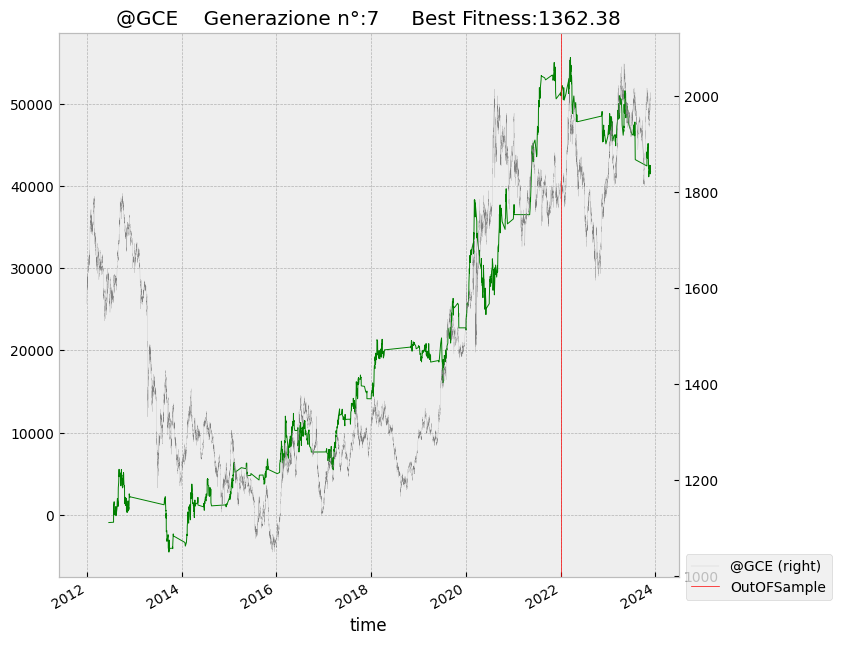

Evolution stopped due to stagnation after 7 generations.

CPU times: total: 13.5 s
Wall time: 17.4 s


In [38]:
%%time

NGEN = 10
NPOP = 1000
NGEN = 10
CXPB = 0.7
MUTPB = 0.2
MAX_STAGNATION = 4
HALL_OF_FAME = 30

stagnation_count = 0

best_fitness = 0 #float('-inf')  

pop = toolbox.population(n=NPOP) 

hall_of_fame = tools.HallOfFame(maxsize=HALL_OF_FAME)

list1 = ["Take Profit:" , "Stop Loss:" , "Exit_bar:" , "Entry Level:" , "Entry Rule 0:" , "Entry Rule 1:" , "Exit Rule:" , "Direzione:" , "Tipo Ordine:" ,  "Add Rule:" , "Regime Filter" ,"Fitness:" , "Min. Operations:" , "Out Of Sample:"]
best_individual = ["None"] * len (list1)
last_best_individual = best_individual

my_hall_of_fame = []

for gen in range(NGEN):

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if True: #random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if True: #random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = ray.get([evaluate.remote(ind) for ind in invalid_ind])
    
    # Assegnazione dei valori di fitness agli individui corrispondenti
    for ind, fit in zip(invalid_ind , fitnesses):
        ind.fitness.values = fit
     

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    my_hall_of_fame.append(hall_of_fame[:10])
    
    best_individual = list(hall_of_fame)[0]

    clear_output(wait=True)

    if hall_of_fame[0].fitness.values[0] > best_fitness:
        best_fitness = hall_of_fame[0].fitness.values[0]
        stagnation_count = 0
    else:
        stagnation_count += 1

    last_best_individual = best_individual

    list2 = best_individual
    list3 = last_best_individual
    table_data = list(zip(list1, list2, list3))
    print(tabulate(table_data, headers=["Parameter", "Now Best Individual", "Last Best Individual"], tablefmt="grid")) 
    
    tradelist = evaluate_backtest(best_individual,False)
    
    tradelist.operations.cumsum().plot(color="green" ,linewidth=0.7 , label="Operations" , title=SIMBOLO+"    Generazione n°:"+str(gen)+"     Best Fitness:"+str(round(best_fitness,2)))
    
    dataset["close"].plot(secondary_y=True , color="grey" ,linewidth=0.1 , label=SIMBOLO)
    
    plt.axvline(x=best_individual[-1] , color="red" , label="OutOFSample")
    
    plt.legend(loc="center left",bbox_to_anchor=(1,0))
    
    plt.show()

    if stagnation_count >= MAX_STAGNATION :
        print(f"Evolution stopped due to stagnation after {gen} generations.")
        print("")
        break

+------------------+------------------------------------------------+
| Parameter        | Best Individual                                |
+==================+================================================+
| Take Profit:     | 350                                            |
+------------------+------------------------------------------------+
| Stop Loss:       | 350                                            |
+------------------+------------------------------------------------+
| Exit_bar:        | 5                                              |
+------------------+------------------------------------------------+
| Entry Level:     | history.low.rolling(5).mean()                  |
+------------------+------------------------------------------------+
| Entry Rule 0:    | history.close.shift(6)<history.high.shift(1)   |
+------------------+------------------------------------------------+
| Entry Rule 1:    | history.high.shift(6)>history.close.shift(2)   |
+------------------+

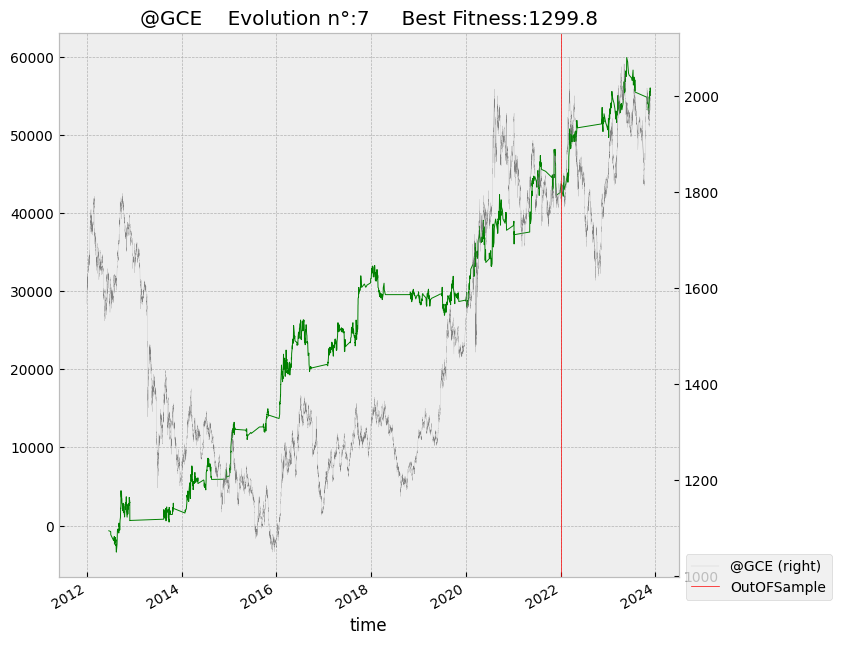

In [33]:
strat = my_hall_of_fame[1]
strat = strat[0]


list2 = strat
table_data = list(zip(list1, list2))
print(tabulate(table_data, headers=["Parameter", "Best Individual"], tablefmt="grid")) 


tradelist = evaluate_backtest(strat,False)

tradelist.operations.cumsum().plot(color="green" ,linewidth=0.7 , label="Operations" , title=SIMBOLO+"    Evolution n°:"+str(gen)+"     Best Fitness:"+str(round(best_fitness,2)))

dataset["close"].plot(secondary_y=True , color="grey" ,linewidth=0.1 , label=SIMBOLO)

plt.axvline(x=best_individual[-1] , color="red" , label="OutOFSample")

plt.legend(loc="center left",bbox_to_anchor=(1,0))

plt.show()

In [34]:
tradelist.tail(20)

,entry_time,entry_price,exit_price,operations,label_event
exit_time,,,,,
2023-11-06 08:00:00,2023-11-06 03:00:00,1993.9,1989.9,-410.0,Stop loss
2023-11-06 16:00:00,2023-11-06 15:00:00,1991.6,1988.0,-370.0,Stop loss
2023-11-06 21:00:00,2023-11-06 19:00:00,1988.2,1984.7,-360.0,Stop loss
2023-11-07 17:00:00,2023-11-07 15:00:00,1966.6,1971.3,460.0,Take profit
2023-11-08 08:00:00,2023-11-08 02:00:00,1975.1,1973.9,-130.0,Exit bar
2023-11-08 15:00:00,2023-11-08 10:00:00,1971.5,1966.2,-540.0,Stop loss
2023-11-09 09:00:00,2023-11-09 03:00:00,1955.0,1953.4,-170.0,Exit bar
2023-11-09 14:00:00,2023-11-09 11:00:00,1951.9,1955.8,380.0,Take profit
2023-11-10 09:00:00,2023-11-10 03:00:00,1963.0,1959.4,-370.0,Exit bar


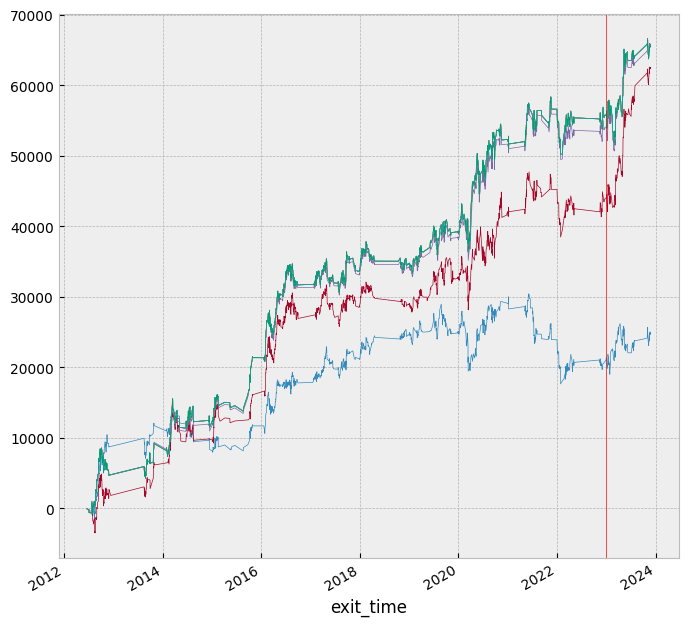

In [31]:
hof = list(hall_of_fame)

for I in my_hall_of_fame:
    e =  I[0]
    tradelist = evaluate_backtest(e,False)
    tradelist.operations.cumsum().plot()
plt.axvline(x="2023-01-01", color="red")

In [170]:
k = (tradelist.operations).values

avg_t = []
avg_dd = []
for e in range(10000):
    np.random.shuffle(k)
    b=np.random.choice(k, size=int(len(k)*0.8))
    avg_t.append(np.sum(b))
    avg_dd.append(abs(My_Max_Drawdown(b)))
round(np.mean(avg_t)/np.mean(avg_dd),2)


3.62

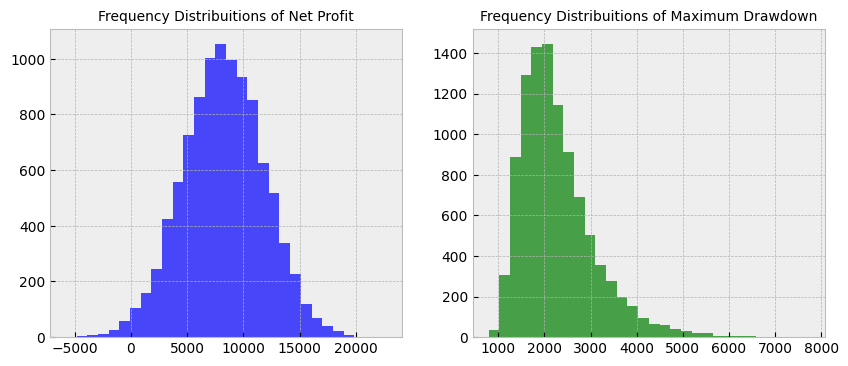

In [171]:
Avg_dd = pd.Series(avg_dd)
Avg_t = pd.Series(avg_t)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne di subplot

# Disegna il primo istogramma nel primo subplot
axs[0].hist(Avg_t, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Frequency Distribuitions of Net Profit' , fontsize=10)

# Disegna il secondo istogramma nel secondo subplot
axs[1].hist(Avg_dd, bins=30, color='green', alpha=0.7)
axs[1].set_title('Frequency Distribuitions of Maximum Drawdown' , fontsize=10)

# Mostra i grafici
plt.show()